<a href="https://colab.research.google.com/github/jjsinger11/clothingCategorization/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gzip
import json
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy as np
import random
import string
from sklearn import linear_model
from nltk.stem.porter import *
from gensim.parsing.preprocessing import remove_stopwords
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
data = list()
with gzip.open('renttherunway_final_data.json.gz', 'rt') as file:
  for line in file:
    data.append(json.loads(line))
print("Length of original dataset: ", len(data))

Length of original dataset:  192544


# Data Cleaning: #

Here we will construct a dataset that contains valid review entries.

In [ ]:
# Remove 'Null' rating entries (removal of 82 entries)
# Removing entries with no 'rented for' label
# Remove unique entry case of party: cocktail

data = [d for d in data if (d['rating'] != None and 'rented for' in d.keys() and d['rented for'] != 'party: cocktail')]
print("Length of cleaned dataset: ", len(data))

Length of cleaned dataset:  192451


In [ ]:
# Randomly shuffling the data to avoid skews in data splits
random.seed(10)
random.shuffle(data)

# Explanatory Analyis: #

Here we will describe the
dataset, including its basic statistics and properties, and report any interesting findings.

In [ ]:
# Create training, validation, and test splits

training_set = data[:8*len(data)//10]
validation_set = data[8*len(data)//10 : 9*len(data)//10]
test_set = data[9*len(data)//10:]


# Number of entries per split

print("Training set length: ", len(training_set))
print("Validation set length: ", len(validation_set))
print("Test set length: ", len(test_set))

Training set length:  153960
Validation set length:  19245
Test set length:  19246


In [ ]:
# Create dictionaries for each user's entries and each item's entries

entriesPerUser = defaultdict(list)
entriesPerItem = defaultdict(list)

for d in training_set:
    entriesPerUser[d['user_id']].append(d)
    entriesPerItem[d['item_id']].append(d)


# Number of unique users and items in the training set

print("Entries per User length", len(entriesPerUser))
print("Entries per Item length", len(entriesPerItem))

Entries per User length 90423
Entries per Item length 5767


In [ ]:
# Obtain "rating" values
# Obtain "rented for" values
# Obtain "review_date" values

ratings = set([int(d['rating']) for d in data])
rented_for = set([d['rented for'] for d in data])
years = set([int(d['review_date'].split()[-1]) for d in data])

# The different options for the two below

print("Ratings: ", ratings)
print("Rented for: ", rented_for)
print("Years: ", sorted(years))


Ratings:  {2, 4, 6, 8, 10}
Rented for:  {'vacation', 'date', 'wedding', 'formal affair', 'party', 'work', 'everyday', 'other'}
Years:  [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]


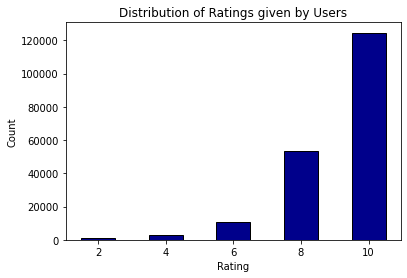

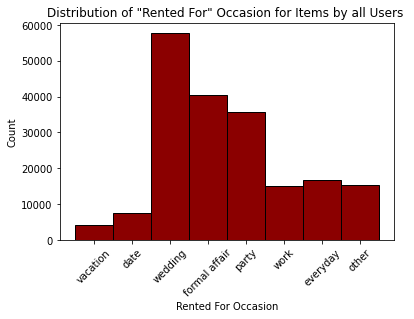

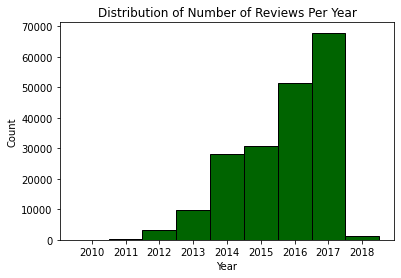

In [ ]:
# Compute distribution of reviews per ratings, reviews per rented for, and reviews per year

rating_tracker = dict(zip(ratings, np.zeros(len(ratings))))
rented_for_tracker = dict(zip(rented_for, np.zeros(len(rented_for))))
years_tracker = dict(zip(years,np.zeros(len(years))))

for d in data:
  rating_tracker[int(d['rating'])] += 1
  rented_for_tracker[d['rented for']] += 1
  years_tracker[int(d['review_date'].split()[-1])] += 1

# Histograms of the above distributions

plt.bar(rating_tracker.keys(),rating_tracker.values(),align='center',width=1,color='darkblue',edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings given by Users')
plt.show()

plt.figure()
plt.bar(rented_for_tracker.keys(),rented_for_tracker.values(),align='center',width=1,color='darkred',edgecolor='black')
plt.xlabel('Rented For Occasion')
plt.ylabel('Count')
plt.title('Distribution of "Rented For" Occasion for Items by all Users ')
plt.xticks(rotation=45)
plt.show()

plt.figure()
plt.bar(years_tracker.keys(),years_tracker.values(),align='center',width=1,color='darkgreen',edgecolor='black')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Distribution of Number of Reviews Per Year')
plt.xticks(sorted(years))
plt.show()

In [ ]:
for i in rented_for_tracker.keys():
  print((i,rented_for_tracker[i]))

('vacation', 4073.0)
('date', 7387.0)
('wedding', 57768.0)
('formal affair', 40365.0)
('party', 35613.0)
('work', 15042.0)
('everyday', 16822.0)
('other', 15381.0)


# Predictive Task: #

Given the user’s review on a particular item, we will predict the (‘rented for’) category for the occasion for which the item will be used.

In [ ]:
test_predictions = [d['rented for'] for d in test_set] # The list of original labels in test set
validation_predictions = [d['rented for'] for d in validation_set] # The list of original labels in validation set

def accuracy(prediction, test):
  correct = np.array(prediction) == np.array(test)
  return sum(correct)/len(correct)

In [ ]:
# Baseline Function and accuracy test

catDict = rented_for_tracker.keys()
baseline_predictions = list()

for l in test_set:
  cat = random.choice(('other', 'wedding')) # If there's no evidence, just choose the most common category/"other"

  review = (l['review_text'] + l['review_summary']).lower()
  for key in catDict:
    if key in review and key != 'other':
      cat = key
  baseline_predictions.append(cat)

print("Baseline Accuracy:", accuracy(baseline_predictions, test_predictions))

Baseline Accuracy: 0.36168554504832173


In [ ]:
# Model 1 - LinearSVC model on Bag-of-Words approach

def feature_BOW(datum, words, wordId, tolower=True, removePunct=True):
    feat = [0]*len(words)
    punctuation = set(string.punctuation)
    r = datum['review_text'] + datum['review_summary']
    if tolower:
        r = r.lower()
    if removePunct:
        r = ''.join([c for c in r if not c in punctuation])
    for w in r.split():
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) # offset
    return feat

def pipeline_BOW(dSize = 1000, tolower=True, removePunct=True):
    wordCount = defaultdict(int)
    punctuation = set(string.punctuation)
    for d in training_set: # Strictly, should just use the *training* data to extract word counts
        r = d['review_text'] + d['review_summary']
        if tolower:
            r = r.lower()
        if removePunct:
            r = ''.join([c for c in r if not c in punctuation])
        for w in r.split():
            wordCount[w] += 1

    counts = [(wordCount[w], w) for w in wordCount]
    counts.sort()
    counts.reverse()

    words = [x[1] for x in counts[:dSize]]

    wordId = dict(zip(words, range(len(words))))
    wordSet = set(words)

    Xtrain = csr_matrix([feature_BOW(d, words, wordId, tolower, removePunct) for d in training_set])
    Xvalid = csr_matrix([feature_BOW(d, words, wordId, tolower, removePunct) for d in validation_set])
    ytrain = [d['rented for'] for d in training_set]
    yvalid = [d['rented for'] for d in validation_set]

    mod_BOW = svm.LinearSVC(C=0.7).fit(Xtrain, ytrain)
    predict = mod_BOW.predict(Xvalid)
    return accuracy(predict, yvalid)

print("Accuracy using Bag of Words and LinearSVC: ", pipeline_BOW())

Accuracy using Bag of Words and LinearSVC:  0.572928033255391


In [ ]:
# Model 2 - Logistic Regression model on Bag-of-Words approach

def feature_BOW(datum, words, wordId, tolower=True, removePunct=True):
    feat = [0]*len(words)
    punctuation = set(string.punctuation)
    r = datum['review_text'] + datum['review_summary']
    if tolower:
        r = r.lower()
    if removePunct:
        r = ''.join([c for c in r if not c in punctuation])
    for w in r.split():
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) # offset
    return feat

def pipeline_BOW(dSize = 1000, tolower=True, removePunct=True):
    wordCount = defaultdict(int)
    punctuation = set(string.punctuation)
    for d in training_set: # Strictly, should just use the *training* data to extract word counts
        r = d['review_text'] + d['review_summary']
        if tolower:
            r = r.lower()
        if removePunct:
            r = ''.join([c for c in r if not c in punctuation])
        for w in r.split():
            wordCount[w] += 1

    counts = [(wordCount[w], w) for w in wordCount]
    counts.sort()
    counts.reverse()

    words = [x[1] for x in counts[:dSize]]

    wordId = dict(zip(words, range(len(words))))
    wordSet = set(words)

    Xtrain = csr_matrix([feature_BOW(d, words, wordId, tolower, removePunct) for d in training_set])
    Xvalid = csr_matrix([feature_BOW(d, words, wordId, tolower, removePunct) for d in validation_set])
    ytrain = [d['rented for'] for d in training_set]
    yvalid = [d['rented for'] for d in validation_set]

    mod_BOW_lin = linear_model.LogisticRegression(C=0.7, solver='sag').fit(Xtrain, ytrain)
    predict = mod_BOW_lin.predict(Xvalid)
    return accuracy(predict, yvalid)

print("Accuracy using Bag of Words and Logistic Regression: ", pipeline_BOW())

Accuracy using Bag of Words and Logistic Regression:  0.5729799948038452


In [ ]:
# Model 3 - TFIDF Vectorizer

train_data_texts = [x['review_text'] + x['review_summary'] for x in training_set]
validation_data_texts = [x['review_text'] + x['review_summary'] for x in validation_set]
train_data_labels = [x['rented for'] for x in training_set]

text_transformer = TfidfVectorizer()
tranformed_train_text = text_transformer.fit_transform(train_data_texts)
transformed_validation_text = text_transformer.transform(validation_data_texts)

mod_tfidfvect = linear_model.LogisticRegression(C=0.755, solver='sag')
mod_tfidfvect.fit(tranformed_train_text, train_data_labels)
pred_tfidfvect = mod_tfidfvect.predict(transformed_validation_text)

accu_tfidfvect = accuracy(pred_tfidfvect , validation_predictions)
print("Accuracy using TF-IDF vectorizer library: ", accu_tfidfvect)


Accuracy using TF-IDF vectorizer library:  0.5951675759937646


In [ ]:
# Model 4 - Naive Bayes

train_data_texts = [x['review_text'] + x['review_summary'] for x in training_set]
validation_data_texts = [x['review_text'] + x['review_summary'] for x in validation_set]
train_data_labels = [x['rented for'] for x in training_set]

text_transformer = CountVectorizer(stop_words='english', lowercase=True)
tranformed_train_text = text_transformer.fit_transform(train_data_texts)
transformed_validation_text = text_transformer.transform(validation_data_texts)

model_NB = MultinomialNB()
model_NB.fit(tranformed_train_text, train_data_labels)
pred_NB = model_NB.predict(transformed_validation_text)

accu_NB = accuracy(pred_NB , validation_predictions)
print("Accuracy using Naive Bayes: ", accu_NB)

Accuracy using Naive Bayes:  0.5672122629254351


In [ ]:
# Model 5 - Count Vectorizer

train_data_texts = [x['review_text'] + x['review_summary'] for x in training_set]
validation_data_texts = [x['review_text'] + x['review_summary'] for x in validation_set]
train_data_labels = [x['rented for'] for x in training_set]

text_transformer = CountVectorizer(stop_words='english', lowercase=True)
tranformed_train_text = text_transformer.fit_transform(train_data_texts)
transformed_validation_text = text_transformer.transform(validation_data_texts)

mod_countvect = linear_model.LogisticRegression(C=0.7, solver='sag')
mod_countvect.fit(tranformed_train_text, train_data_labels)
pred_countvect = mod_countvect.predict(transformed_validation_text)

accu_countvect = accuracy(pred_countvect , validation_predictions)
print("Accuracy using Count vectorizer library: ", accu_countvect)


Accuracy using Count vectorizer library:  0.5822291504286827
